In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import shutil

from utils import plot_boxplots, print_latex_table

import warnings
warnings.filterwarnings('ignore')

In [2]:
log_dir = '/scratch/midway3/jshe/molecular-attention-bias/'

## Load data from log directory

In [16]:
logs = []
test_losses = []
for root, dirs, files in os.walk(log_dir):
    if not files: continue
    if 'model.pt' not in files: 
        # shutil.rmtree(root)
        continue
    
    *_, dataset, targets, model_type, radial_function_type, architecture, run_id = root.split('/')

    log_file = os.path.join(root, 'log.csv')
    test_losses_file = os.path.join(root, 'test_losses.csv')

    # Load log file

    log = pd.read_csv(log_file)
    if 'lr' in log.columns: log = log.drop(columns=['lr'])

    log.columns = [col.replace('_', '&') for col in log.columns]
    log.columns = [f'{dataset}&{targets}&{model_type}&{radial_function_type}&{architecture}&{col}&{run_id}' for col in log.columns]
    logs.append(log)

    # Load test metrics file

    if os.path.exists(test_losses_file):
        losses = pd.read_csv(test_losses_file)
        losses.columns = [col.replace('_per_atom', 'peratom').replace('_', '&') for col in losses.columns]
        losses.columns = [f'{dataset}&{targets}&{model_type}&{radial_function_type}&{architecture}&{col}&{run_id}' for col in losses.columns]
        test_losses.append(losses)

# Concatenate logs

logs = pd.concat(logs, axis=1)
tuples = [tuple(col.split('&')) for col in logs.columns]

logs.columns = pd.MultiIndex.from_tuples(
    tuples, 
    names=['dataset', 'targets', 'model_type', 'radial_function_type', 'architecture', 'split', 'property', 'metric', 'run_id']
)

# Concatenate test metrics

test_losses = pd.concat(test_losses, axis=1)
tuples = [tuple(col.split('&')) for col in test_losses.columns]

test_losses.columns = pd.MultiIndex.from_tuples(
    tuples, 
    names=['dataset', 'targets', 'model_type', 'radial_function_type', 'architecture', 'split', 'property', 'metric', 'run_id']
)

## Single model ensemble loss curves

In [56]:
dataset = 'qm9'
targets = 'U0_U_H_G'
model_type = 'BiasedAttentionTransformer'
radial_function_type = 'Mixed-1'
architecture = 'E128H8D8'

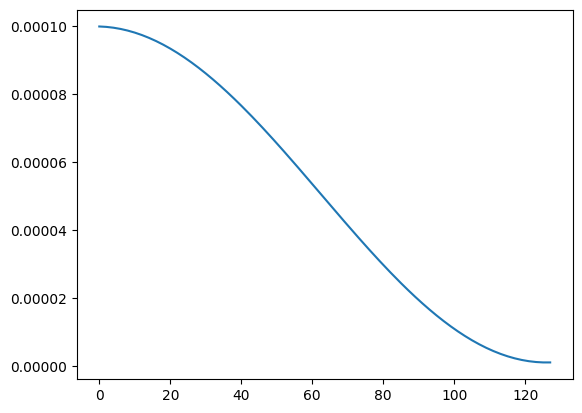

In [57]:
path = log_dir + f'{dataset}/{targets}/{model_type}/{radial_function_type}/{architecture}/'

fig, ax = plt.subplots()

for run_id in os.listdir(path):
    log = pd.read_csv(path + run_id + '/log.csv')
    ax.plot(log['lr'])

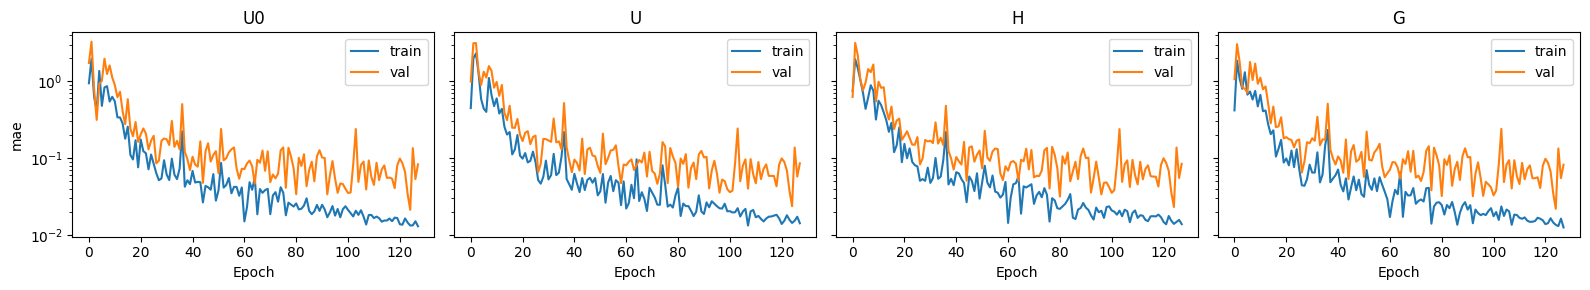

In [59]:
splits = logs[dataset, targets].columns.get_level_values('split').unique()
properties = logs[dataset, targets].columns.get_level_values('property').unique()
metrics = logs[dataset, targets].columns.get_level_values('metric').unique()

fig, axs = plt.subplots(
    len(metrics), len(properties), 
    figsize=(len(properties) * 4, len(metrics) * 3), 
    sharex=True, sharey='row'
)
if type(axs) is not np.ndarray: axs = np.array([axs])
if axs.ndim == 1: axs = axs[np.newaxis, :]

for column, prop in enumerate(properties):
    axs[0, column].set_title(prop)
    for row, metric in enumerate(metrics):
        axs[row, 0].set_ylabel(metric)
        if row == len(metrics) - 1: axs[row, column].set_xlabel('Epoch')
        for split in splits:
            # if split == 'train': continue
            ax = axs[row, column]

            log = logs[dataset, targets, model_type, radial_function_type, architecture, split, prop, metric]

            # Plot mean and standard deviation

            mean = log.mean(axis=1)
            std = log.std(axis=1)
            ax.plot(mean, label=split)
            ax.fill_between(x=range(len(log)), y1=mean - std, y2=mean + std, alpha=0.5)

            # # Plot individual runs

            # for i in range(log.shape[1]):
            #     ax.plot(log.iloc[:, i], label=split)

            ax.legend()
            if metric == 'mae': ax.set_yscale('log')

fig.tight_layout()

In [60]:
dataset = 'qm9'
targets = 'U0_U_H_G'

tick_labels = [
    'PowerLaw', 
    'ExpNegativePowerLaw', 
    'Zeros',
    'FixedPowerLaw-2',
    'GaussianKernel32', 
    'Mixed-1'
]

log_specs = [
    ('BiasedAttentionTransformer', 'PowerLaw', 'E128H8D8'),
    ('BiasedAttentionTransformer', 'ExpNegativePowerLaw', 'E128H8D8'),
    ('BiasedAttentionTransformer', 'Zeros', 'E128H8D8'),
    ('BiasedAttentionTransformer', 'FixedPowerLaw-2', 'E128H8D8'),
    ('BiasedAttentionTransformer', 'GaussianKernel32', 'E128H8D8'),
    ('BiasedAttentionTransformer', 'Mixed-1', 'E128H8D8'),
]

[array([0.030092]), array([0.02982306]), array([0.0198205]), array([0.06691467]), array([0.01919827]), array([0.01241984])]
['PowerLaw', 'ExpNegativePowerLaw', 'Zeros', 'FixedPowerLaw-2', 'GaussianKernel32', 'Mixed-1']
[array([0.02115314]), array([0.03361736]), array([0.01840374]), array([0.06865797]), array([0.02022136]), array([0.0136533])]
['PowerLaw', 'ExpNegativePowerLaw', 'Zeros', 'FixedPowerLaw-2', 'GaussianKernel32', 'Mixed-1']
[array([0.02756366]), array([0.02819765]), array([0.01945424]), array([0.06716096]), array([0.02232397]), array([0.01327897])]
['PowerLaw', 'ExpNegativePowerLaw', 'Zeros', 'FixedPowerLaw-2', 'GaussianKernel32', 'Mixed-1']
[array([0.02430315]), array([0.02968121]), array([0.02018709]), array([0.06649134]), array([0.02394377]), array([0.01181003])]
['PowerLaw', 'ExpNegativePowerLaw', 'Zeros', 'FixedPowerLaw-2', 'GaussianKernel32', 'Mixed-1']


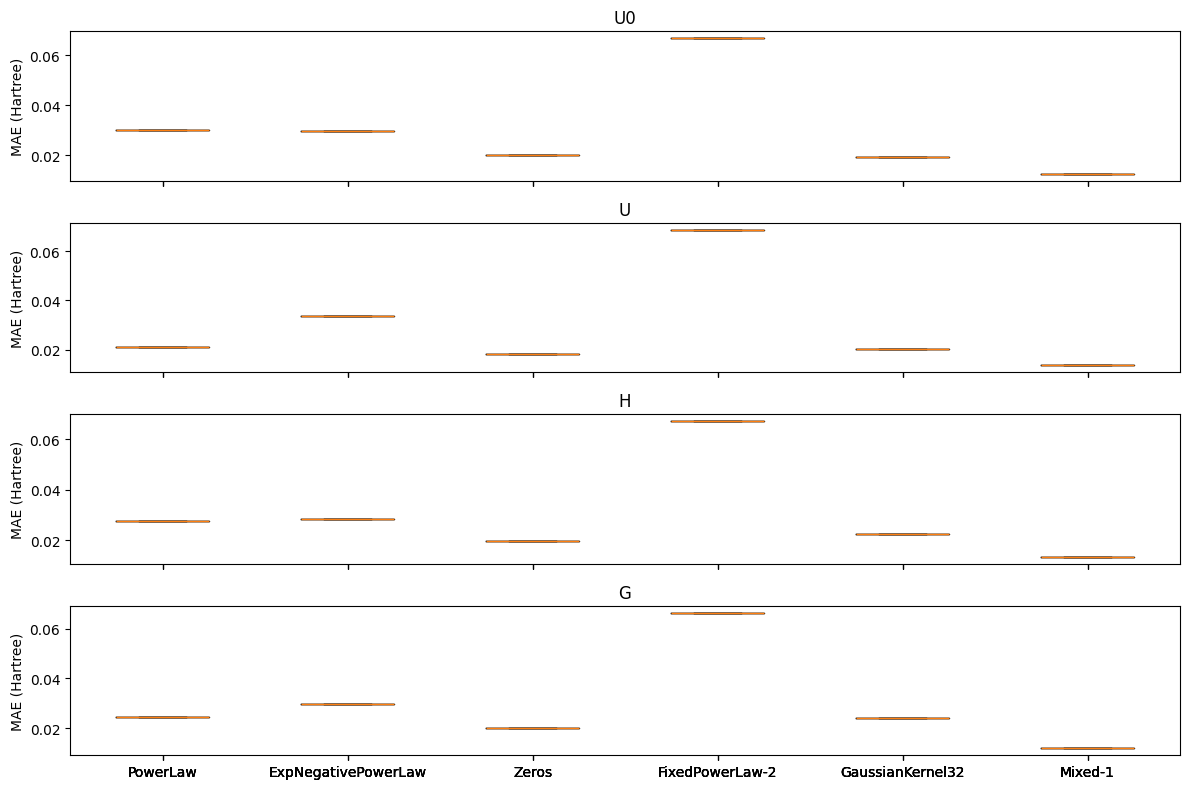

In [63]:
properties = test_losses[dataset, targets].columns.get_level_values('property').unique()
metrics = test_losses[dataset, targets].columns.get_level_values('metric').unique()

fig, axs = plt.subplots(
    len(properties), 1, 
    figsize=(len(log_specs) * 2, len(properties) * 2), 
    sharex=True
)
if not isinstance(axs, np.ndarray): axs = np.array([axs])

for row, prop in enumerate(properties):
    axs[row].set_title(prop)
    axs[row].set_ylabel('MAE (Hartree)')

    data = []
    for model_type, radial_function_type, architecture in log_specs:
        mae = test_losses[dataset, targets, model_type, radial_function_type, architecture, 'test', prop, 'maeperatom'].dropna()
        data.append(mae.to_numpy().squeeze(1))

    print(data)
    print(tick_labels)
    axs[row].boxplot(data, tick_labels=tick_labels)
    
    fig.tight_layout()